
Johannes Schade (5564109)

Yolanda Seifert (5477060)

David Bauer (5398867)

# Variations on private logistic regression:




In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer


from matplotlib import pyplot as plt

2023-01-06 14:30:53.344206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Preparatory task 

* Load the MNIST dataset
* Note that you need a **binarized** version of the MNIST dataset. Also, you need to keep only **2** classes out of ten, namely 5 and 8 
* Rescale the feature values such that each sample has **Euclidean norm** $≤ 1$.
* Split the dataset into train/test/rest sets (10000/1000/-1). 
* Implement in Tensorflow a regularized logistic regression (L2 regularization), i.e. the solution to:
$w^{*} = \text{argmin}_{w} \frac{1}{2} \lambda w^{T}w + \frac{1}{n} \sum_{i = 1}^{n} \log(1 + \exp(-y_{i}w^{T}x_{i})) $ 
* Hint: You need *softmax/sigmoid* and *cross-entropy*! 


In [58]:
# Code for Excercise 1
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

indexes_train = [i for i in range(len(y_train)) if y_train[i] in [5,8] ]
indexes_test = [i for i in range(len(y_test)) if y_test[i] in [5,8] ]

x_train, y_train = np.array([x_train[i] for i in indexes_train]), np.array([[y_train[i]] for i in indexes_train])


# normalize
#x_train = x_train/255.

# binarize
thres = 128.
x_train = np.where(x_train > thres, 1, 0)

#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

max = np.linalg.norm(x_train, axis=0).max()
x_train = np.divide(x_train, max)

# test-train-split
Xtrain, xtest, Ytrain, ytest = train_test_split(x_train, y_train, train_size = 10000)
Xtest, xrest, Ytest, yrest = train_test_split(Xtrain, Ytrain, train_size = 1000)

# reformulate y's
Ytrain = np.where(Ytrain > 5, 1, 0)
Ytest = np.where(Ytest > 5, 1, 0)



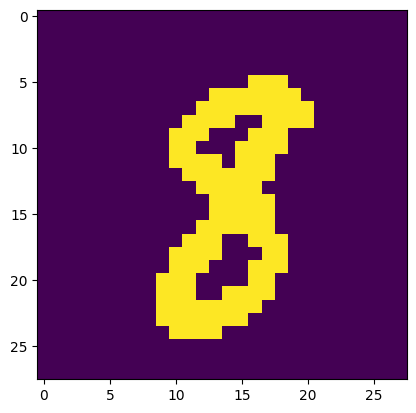

In [59]:
plt.imshow(Xtrain[0])

In [65]:
# Code for Excercise 1
lamb = 1
learning_rate=0.001

def make_log_reg (lamb, learning_rate, verbose=False) :
    log_reg = Sequential()
    log_reg.add(tf.keras.layers.Flatten())
    log_reg.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(lamb), use_bias=True))
    log_reg.add(tf.keras.layers.Activation("sigmoid"))

    log_reg.build(input_shape=(None,28,28))
    if verbose : log_reg.summary()

    optimizer=tf.keras.optimizers.Adam(learning_rate)
    #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    loss = tf.keras.losses.BinaryCrossentropy()
    log_reg.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return log_reg

def train (log_reg, verbose=False) :
    return log_reg.fit(Xtrain, Ytrain, 
                      epochs=20, batch_size=128,
                      validation_split=0.2, 
                      shuffle=True,
                     verbose=verbose)

log_reg = make_log_reg(lamb, learning_rate, verbose=True)
hist = train(log_reg, verbose=True)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_35 (Flatten)        (None, 784)               0         
                                                                 
 dense_44 (Dense)            (None, 1)                 785       
                                                                 
 activation_44 (Activation)  (None, 1)                 0         
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
63/63 [==============================] - 1s 5ms/step - loss: 1.4462 - accuracy: 0.5121 - val_loss: 0.8139 - val_accuracy: 0.5360
Epoch 2/20
63/63 [==============================] - 0s 3ms/step - loss: 0.7267 - accuracy: 0.5155 - val_loss: 0.6944 - val_accuracy: 0.5360
Epoch 3/20
63/63 [=====================

In [44]:
pred = log_reg.predict(Xtest)

32/32 [==============================] - 0s 1ms/step


In [45]:
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='upper left')

NameError: name 'hist' is not defined

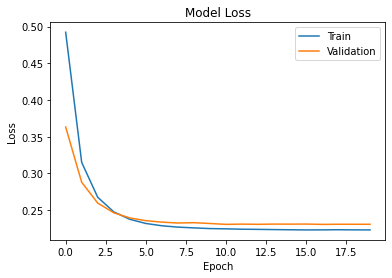

In [129]:
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')

In [130]:
test_loss, test_acc = log_reg.evaluate(Xtest, Ytest)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

32/32 [==============================] - 0s 2ms/step - loss: 0.3882 - accuracy: 0.9310
Test loss: 0.3882017433643341
Test accuracy: 0.9309999942779541


# 2. Output Perturbation: 
* The goal of this excercise is to get a differentially private parameter vector. 
* How. By adding calibrated noise to the parameters derived from non-private logistic regression training. 
* This procedure is called **output perturbation**
* For this, we need an algorithm for privacy-preserving logistic regression, which adds noise to the classifier obtained by logistic regression, proportional to its **sensitivity**. 
<br>
* **Algorithm 1**:
1. - Compute $w^{*}$, the classifier obtained by regularized logistic regression on the labelled examples $(x_{1},y_{1}), ..., (x_{n}, y_{n})$
2. - Pick a noise vector $η$ according to the following density function: $ h({η}) ∝ \exp(\frac{-nϵλ}{2} \lVert η \rVert)$. 
<br> <br> How to choose such a vector: pick the norm of $\eta$ from the $Γ(d, \frac{2}{nϵλ})$ distribution ([Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)), and pick the dirtection of $\eta$ uniformly at random. 
3. - Output $w^{*}+ \eta$ 
<br>
* The following Theorem, and Corollary might be helpful to understand the Algorithm above (Proofs are omitted here): 
* - Theorem: Let $(x_{1},y_{1}), ..., (x_{n},y_{n})$ be a set of labelled points over $\mathbb{R}^{d}$ such that $\lVert x_{i} \rVert \le 1$  for all $i$. Then, Algorithm above preserves $ϵ$-differential privacy.
<br>
* Given a set of n examples $x_{1}, ...,  x_{n}$ in $\mathbb{R}^{d}$, with labels $y_{1}, ..., y_{n}$, such that for all $i$, $\lVert x_{i} \rVert \le 1$, then the sensitivity of logistic regression with regularization parameter $λ$ is at most $\frac{2}{n\lambda}$

4. To access the performance of the algorithm above, we need   to bound its performance on the training data. To do this, we introduce the notation below: 
* - For a classifier $w$, we use $L(w)$ to denote the expected loss of $w$ over the data distribution, and $\hat L (w)$ to denote the empirical average loss of $w$ over the training data. In other words, <br> <br> $ \hat L(w) = \frac{1}{n} \sum_{i = 1} ^{n} log(1 + \exp(-y_{i}w^{T} x_{i}))$, <br>  <br> where  $(x_{i},y_{i}), i = 1, ..., n $ are the training examples. 

* - Further, for a classifier $w$, we use the notation $f_{\lambda}(w)$ to denote the quantity $ \frac{1}{2} λ {\lVert w \rVert}^{2} + L(w)$ and $\hat f_{\lambda}(w)$ to denote the quantity  $ \frac{1}{2} \lambda {\lVert w \rVert} ^{2} + \hat L(w)$. 

* - Finally, we can summarize the guarantees on this algorithm with: <br> <br>
 Given a logistic regression problem with regularization parameter $\lambda$, let $w_{1}$ be the classifier that minimizes $\hat f(\lambda)$, and $w_{2}$ be the classifier output by the algorithm mentioned above, respectively. Then, with probability $1- δ$ over the randomness in the privacy mechanism, <br> <br> $\hat f_{\lambda}(w_{2}) \le \hat f_{\lambda}(w_{1}) + \frac{2d^{2}(1 + \lambda) \log^{2} (\frac{d}{\delta})}{\lambda^{2}n^{2}\epsilon^{2}}$ (Proof is omitted)

* It becomes evident that the performance of the algorithm above degrades with decreasing λ, and is poor in particular when λ is very small. 

- 5. Based on what has been introduced so far, implement the algorithm mentioned above and provide an ϵ vs accuracy plot.



(1, 784, 1)


Text(0.5, 0, 'Epsilon')

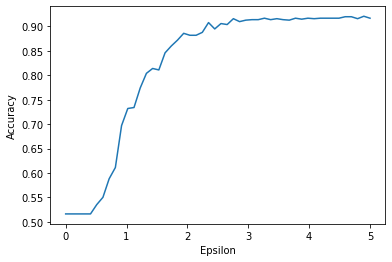

In [133]:
n = 1000
d = 24*24
eps = np.linspace(0.00001,5)


def pick_eta (eps, lamb, n, d, size) :
  assert eps > 0
  eta_norm = np.random.gamma(d, 2/(eps*lamb*n))

  eta = np.random.uniform(0, 1, size)
  eta = (eta/eta.sum()) * eta_norm
  
  return eta


def get_acc(mdl, eps, lamb):
  acc = []
  weights = np.asarray(mdl.get_weights())
  print(weights.shape)
  for e in eps:
    eta = pick_eta(e, lamb, n, d, weights.shape[1]).reshape(weights.shape)
    tmp_mdl = make_log_reg(lamb, learning_rate)
    
    tmp_mdl.set_weights(weights + eta)
    test_loss, test_acc = tmp_mdl.evaluate(Xtest, Ytest, verbose=False)
    acc.append(test_acc)
  return acc

acc = get_acc(log_reg, eps, lamb)
plt.plot(eps, acc)
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')

# 3. Objective Perturbation

* In this excercise we want to implement an privacy-preserving approximation algorithm to logistic regression, which has better performance bounds for small λ. 
* The input to this algorithm is s a set of examples $x_{1}, ..., x_{n}$ over $\mathbb{R}^{d}$ such that $\lVert x_{i} \rVert \le 1$ for all $i$, a set of labels $y_{1}, ..., y_{i}$ for the examples, a regularization constant $\lambda$ and a privacy parameter $\epsilon$ and the output is a vector $w^{*}$ in $\mathbb{R}^{d}$. <br> <br>

* Algorithm 2: 

  - Pick  a random vector $b$ from the density function $ h(b) \propto \exp{(\frac{-ϵ}{2}\lVert b \rVert)}$ 
  - How to implement this? Pick the norm of $b$ from the $Γ(d,\frac{2}{ϵ})$ distribution,  and the direction of $b$ uniformly at
random. 
  -  Given examples $x_{1}, ..., x_{n}$ with the labels $y_{1}, ... y_{n}$ and a regularization constant $\lambda$, compute  <br><br> $ w^{*} = \text{argmin}_{w} \frac{1}{2} \lambda w^{T} w + \frac{b^{T}w}{n} + \frac{1}{n} \sum_{i = 1} ^{n} \log(1 + \exp{(-y_{i}w^{T}x_{i})})$

  - Finally, output $w^{*}$


* Algorithm 2 is privacy preserving, however, we will omit the proof here. 

* Plot  $ϵ$ vs accuracy  for $λ = [0.01, 0.1, 1, 10, 100 ]$ for both algorithms. 

* Interprete the results



In [153]:
# Code for excercise above 


def pick_b (eps, lamb, n, d, size) :
  assert eps > 0
  b_norm = np.random.gamma(d, 2/eps)

  b = np.random.uniform(0, 1, size)
  b = (b/b.sum()) * b_norm
  
  return b

def get_acc2(mdl, eps, lamb):
  acc = []
  weights = np.asarray(mdl.get_weights())
  print(weights.shape)
  for e in eps:
    b = pick_b(e, lamb, n, d, weights.shape[1]).reshape(weights.shape)
    tmp_mdl = make_log_reg(lamb, learning_rate)

    tmp_mdl.set_weights(weights + (b.T * weights/n))
    test_loss, test_acc = tmp_mdl.evaluate(Xtest, Ytest, verbose=False)
    acc.append(test_acc)
  return acc


eps = np.logspace(-20,0)

acc = get_acc2(log_reg, eps, lamb)

(1, 784, 1)


In [154]:
print(eps)

[1.00000000e-20 2.55954792e-20 6.55128557e-20 1.67683294e-19
 4.29193426e-19 1.09854114e-18 2.81176870e-18 7.19685673e-18
 1.84206997e-17 4.71486636e-17 1.20679264e-16 3.08884360e-16
 7.90604321e-16 2.02358965e-15 5.17947468e-15 1.32571137e-14
 3.39322177e-14 8.68511374e-14 2.22299648e-13 5.68986603e-13
 1.45634848e-12 3.72759372e-12 9.54095476e-12 2.44205309e-11
 6.25055193e-11 1.59985872e-10 4.09491506e-10 1.04811313e-09
 2.68269580e-09 6.86648845e-09 1.75751062e-08 4.49843267e-08
 1.15139540e-07 2.94705170e-07 7.54312006e-07 1.93069773e-06
 4.94171336e-06 1.26485522e-05 3.23745754e-05 8.28642773e-05
 2.12095089e-04 5.42867544e-04 1.38949549e-03 3.55648031e-03
 9.10298178e-03 2.32995181e-02 5.96362332e-02 1.52641797e-01
 3.90693994e-01 1.00000000e+00]


Text(0.5, 0, 'Epsilon')

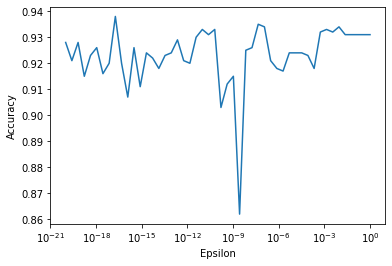

In [155]:
plt.plot(eps, acc)
plt.xscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')

# Comparison of both algorithms

Algorithm 2 is incorrect, we decided to omit those plots

In [168]:
lamb_list = np.logspace(-2,2,5)
#eps = np.linspace(0.00001,5)
eps = np.logspace(-1,1)
res = []

for lamb in lamb_list :
  log_reg = make_log_reg(lamb, learning_rate)
  train(log_reg)
  acc = get_acc(log_reg, eps, lamb)
  res.append(acc)

(1, 784, 1)
(1, 784, 1)
(1, 784, 1)
(1, 784, 1)
(1, 784, 1)


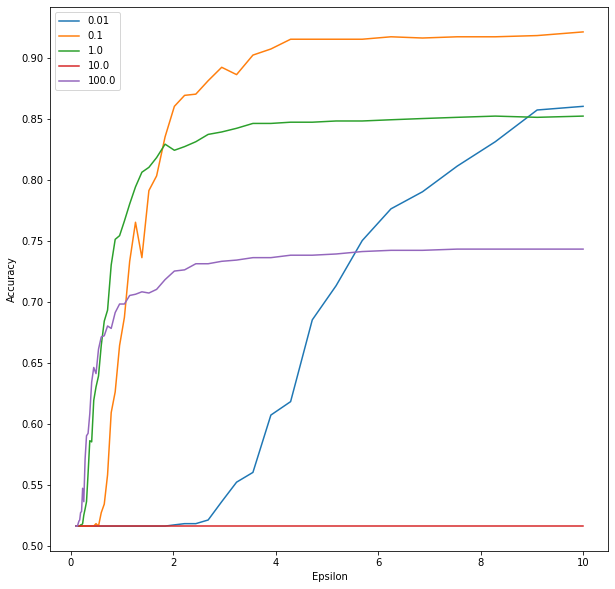

In [172]:
fig = plt.figure(figsize=(10,10))

for i, lamb in enumerate(lamb_list) :
  plt.plot(eps, res[i], label=lamb)
  
#plt.xscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.legend()